# Exemple sur le modèle jouet Campbell

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from kernels import *
from methods import ACP,ACPF_Ondelettes,lhs_optimized

In [3]:
def Simulateur(x,z1,z2):
  return x[0]*np.exp(-(0.8*z1+0.2*z2-10*x[1])**2/(60*x[0]**2))+(x[1]+x[3])*np.exp((0.5*z1+0.5*z2)*x[0]/500)+x[4]*(x[2]-2)*np.exp(-(0.4*z1+0.6*z2-20*x[5])**2/(40*x[4]**2))+(x[5]+x[7])*np.exp((0.3*z1+0.7*z2)*x[6]/250)

#x=np.array([-1,-1,-1,-1,-1,-1,-1,-1])
#x=np.array([5,5,5,5,5,5,5,5])
x=np.array([5,3,1,-1,5,3,1,-1])

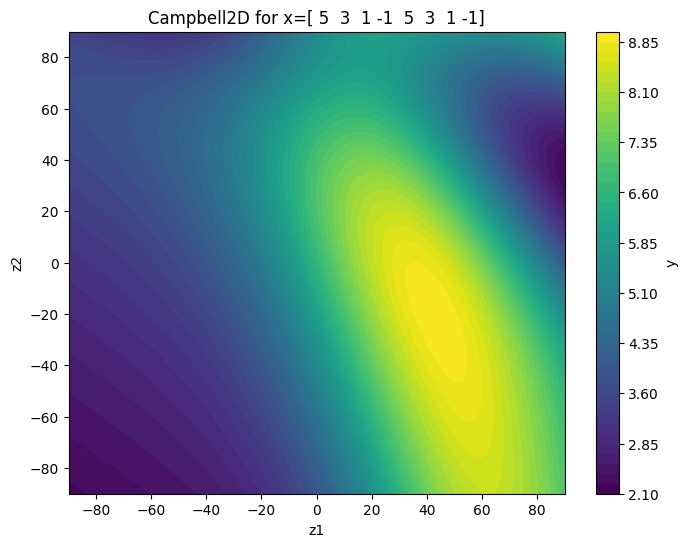

In [4]:
n_grid = 64
D = n_grid**2
z1_vals=np.linspace(-90,90,n_grid)
z2_vals=np.linspace(-90,90,n_grid)

Z1,Z2=np.meshgrid(z1_vals,z2_vals)

Y = Simulateur(x, Z1, Z2)
plt.figure(figsize=(8, 6))
contour = plt.contourf(Z1, Z2, Y, levels=50)
plt.colorbar(contour, label='y')
plt.xlabel('z1')
plt.ylabel('z2')
plt.title(f'Campbell2D for x={x}')
plt.show()

In [5]:
n_test=1000
n_train = 200
n_dim = 8
bounds = np.array([-np.ones(n_dim),5*np.ones(n_dim)])
x_train = lhs_optimized(n_train, n_dim ,bounds, n_iter=500, seed=42)#on simule les données d'entrée avec LHS et SA
x_test=np.random.uniform(-1,5,(n_test,n_dim)) #On simule les données de test avec une loi uniforme
y_train = np.zeros((n_train,n_grid*n_grid))  # matrice (1000, 4096)
y_test = np.zeros((n_test,n_grid*n_grid))
for i in range(n_train):
    ytrain_i = Simulateur(x_train[i], Z1, Z2)
    ytest_i = Simulateur(x_test[i], Z1, Z2)
    y_train[i,:]=ytrain_i.flatten()  # on aplati la carte 64x64 pour pouvoir faire l'ACP
    y_test[i,:]=ytest_i.flatten()
print("Forme de y :",y_train.shape)

Forme de y : (200, 4096)


## Méthode par ACP

In [6]:
#La fonction est dans le fichier methods.py
n_pc = 5 #nombre composantes principales
theta = 0.01
sigma = 1
kernel = mat5_2Kern
Y_test_reconstruct,Var_Y_reconstruct = ACP(x_train,x_test,y_train,n_pc,[theta,sigma],kernel)

Variance expliquée par les 5 premières composantes : [0.7555028  0.14558129 0.03848246 0.01974575 0.0169879 ]
Variance globale expliquée : 0.9763002020433148
Taille du jeu d'entrainement transformé par ACP : (200, 5)


Affichage des résultats en 2D

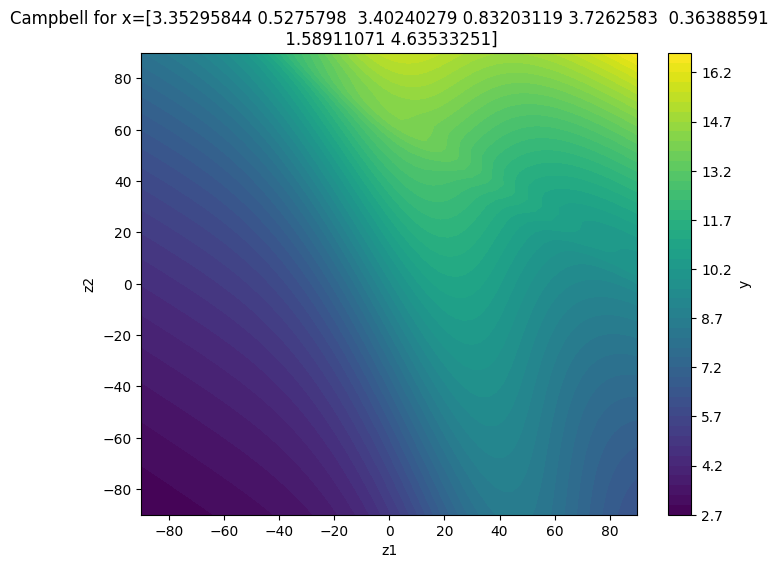

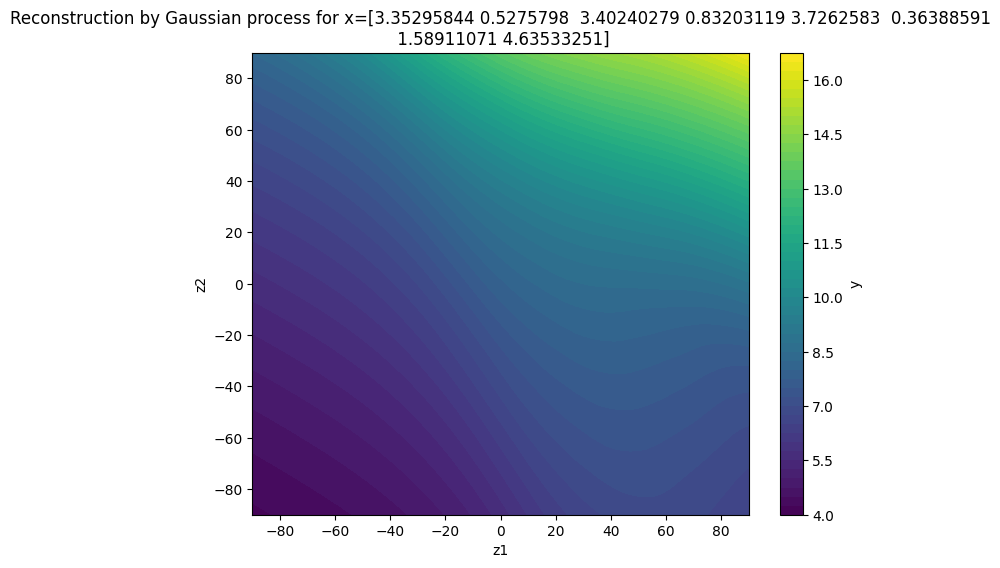

In [7]:
z1_vals=np.linspace(-90,90,n_grid)
z2_vals=np.linspace(-90,90,n_grid)

Z1,Z2=np.meshgrid(z1_vals,z2_vals)

#Vérité
plt.figure(figsize=(8, 6))
contour = plt.contourf(Z1, Z2, np.reshape(y_test[100,:],(n_grid,n_grid)), levels=50)
plt.colorbar(contour, label='y')
plt.xlabel('z1')
plt.ylabel('z2')
plt.title(f'Campbell for x={x_test[10,:]}')
plt.show()

#Prédiction
plt.figure(figsize=(8, 6))
contour = plt.contourf(Z1, Z2, np.reshape(Y_test_reconstruct[100,:],(n_grid,n_grid)), levels=50)
plt.colorbar(contour, label='y')
plt.xlabel('z1')
plt.ylabel('z2')
plt.title(f'Reconstruction by Gaussian process for x={x_test[10,:]}')
plt.show()

On a des résultats intéressants, on obtient des valeurs dans des intervalles similaires (pas de valeurs abérrantes). Maintenant, il faut vérifier toutes les formules pour être sûr qu'on obtient les bonnes valeurs de la méthode. 
Après normalement, la PCA seule donne les moins bons résultats. Il faut qu'on implémente la métrique RMSE et les 2 autres méthodes (ACPF avec ondelettes et B-splines) pour pouvoir comparer. 
Une fois qu'on aura les trois méthodes, on pourra ajouter une optimisation des hyper-paramètres: nombre de composantes de l'ACP et nombre de coeffs pour les décompositions Ondelettes et B-spline.

# RMSE

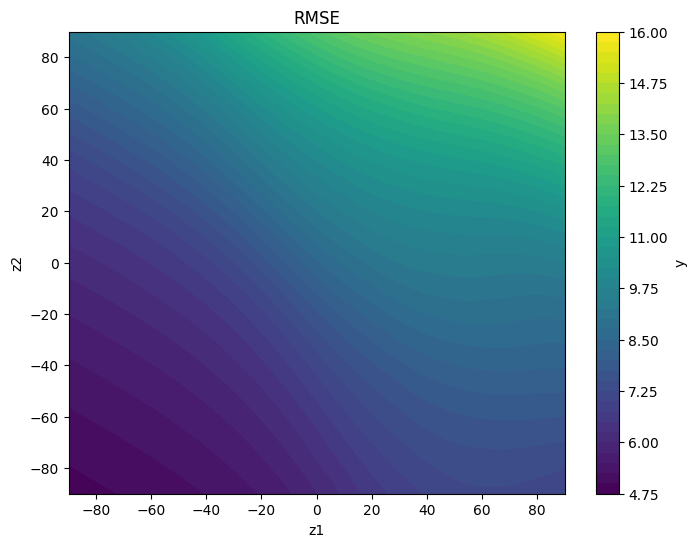

In [8]:
# y_test et Y_test_reconstruct ont la forme (n_test, n_grid*n_grid) = (1000, 4096)
rmse_per_pixel = np.sqrt(np.mean((y_test - Y_test_reconstruct)**2, axis=0)) #formule (3.17) page 46 de la thèse
RMSE_map = rmse_per_pixel.reshape((n_grid, n_grid))

plt.figure(figsize=(8, 6))
contour = plt.contourf(Z1, Z2, RMSE_map, levels=50)
plt.colorbar(contour, label='y')
plt.xlabel('z1')
plt.ylabel('z2')
plt.title(f'RMSE')
plt.show()

La carte RMSE ne semble pas très convaincante. Je n'ai aucune idée de pourquoi elle a ce comportement et pourquoi je ne retrouve pas la même que celle de la thèse... :(

## ACPF avec base d'ondelette

In [9]:
n_pc = 5 #nombre composantes principales
K_tilde = 1200
p = 0.95
theta = 0.01
sigma = 1
kernel = mat5_2Kern
Y_reconstruct = ACPF_Ondelettes(x_train,x_test,y_train,n_pc,[theta,sigma],kernel,K_tilde=0,p=p)

Nombre de coefficients conservés pour l'ACP : 1824
Variance expliquée par les 5 premières composantes : [0.78577571 0.12101166 0.03204269 0.02188138 0.01639572]
Variance globale expliquée : 0.9771071627787073
Taille du jeu d'entrainement transformé par ACP : (200, 5)


Affichage du résultat en 2D

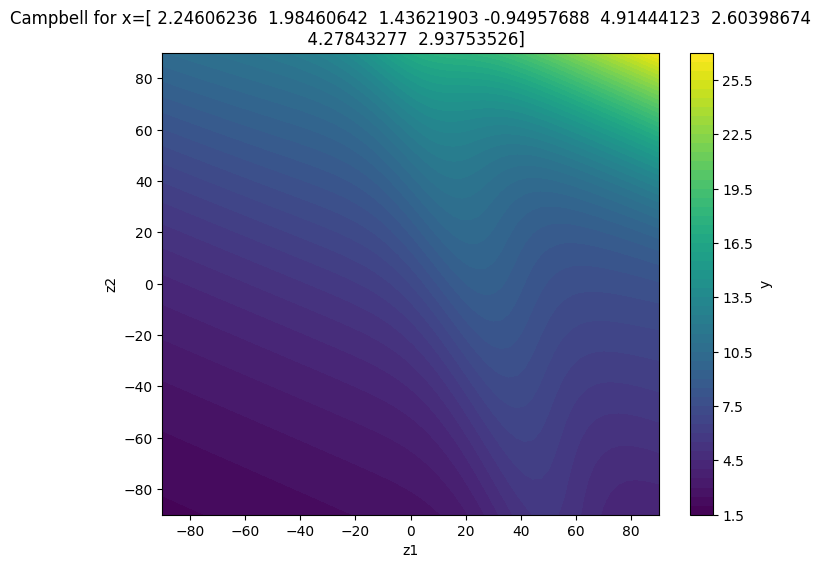

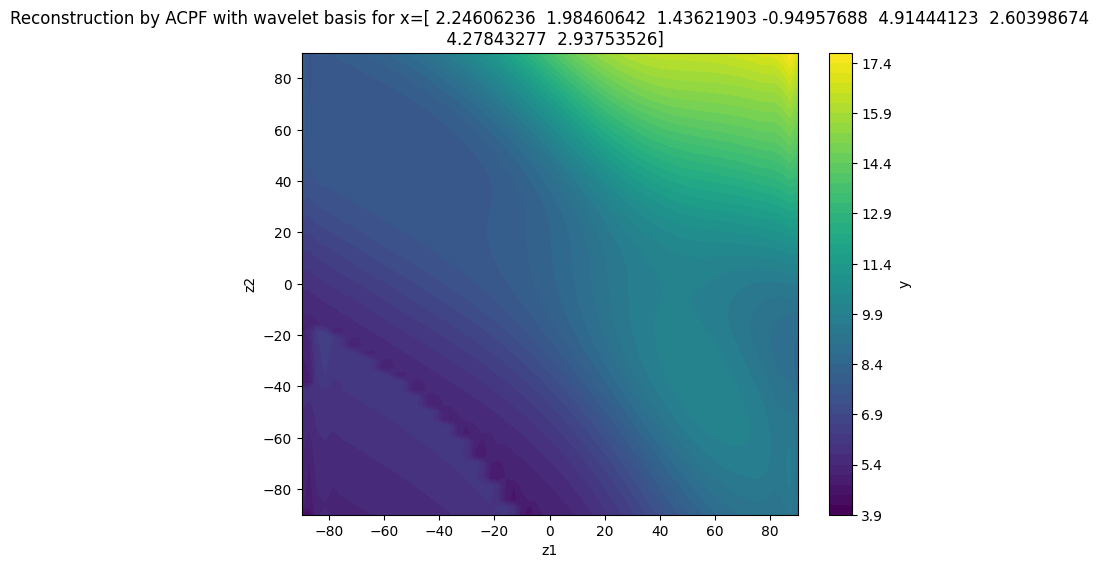

In [10]:
#Vérité
plt.figure(figsize=(8, 6))
contour = plt.contourf(Z1, Z2, np.reshape(y_test[5,:],(n_grid,n_grid)), levels=50)
plt.colorbar(contour, label='y')
plt.xlabel('z1')
plt.ylabel('z2')
plt.title(f'Campbell for x={x_test[5,:]}')
plt.show()

#Prédiction
plt.figure(figsize=(8, 6))
contour = plt.contourf(Z1, Z2, np.reshape(Y_reconstruct[5,:],(n_grid,n_grid)), levels=50)
plt.colorbar(contour, label='y')
plt.xlabel('z1')
plt.ylabel('z2')
plt.title(f'Reconstruction by ACPF with wavelet basis for x={x_test[5,:]}')
plt.show()

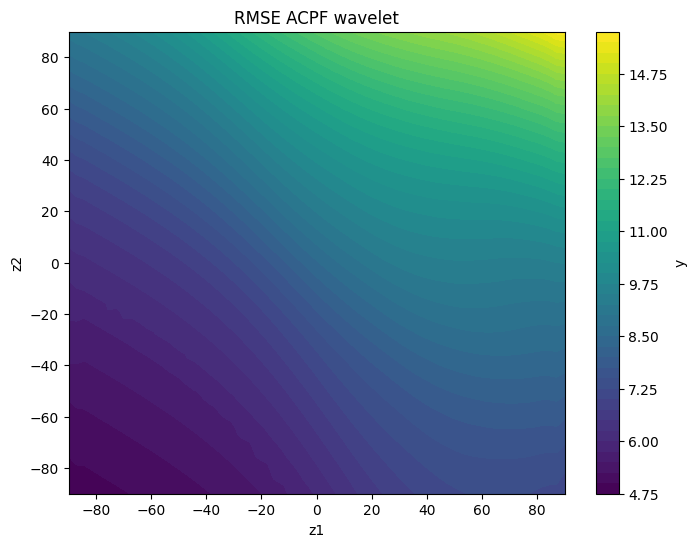

In [11]:
# y_test et Y_test_reconstruct ont la forme (n_test, n_grid*n_grid) = (1000, 4096)
rmse_wavelet_per_pixel = np.sqrt(np.mean((y_test - Y_reconstruct)**2, axis=0)) #formule (3.17) page 46 de la thèse
RMSE_wavelet_map = rmse_wavelet_per_pixel.reshape((n_grid, n_grid))

plt.figure(figsize=(8, 6))
contour = plt.contourf(Z1, Z2, RMSE_wavelet_map, levels=50)
plt.colorbar(contour, label='y')
plt.xlabel('z1')
plt.ylabel('z2')
plt.title(f'RMSE ACPF wavelet')
plt.show()